In [58]:
import pandas as pd
from enum import Enum
import numpy as np
import yfinance as yf
import random

In [8]:
clean_data = yf.download('TSLA', period='max')

def make_data_messy(df, missing_rows=100, nan_values=200, zero_volume_days=100, price_shock_factor=2.0):
    messy_df = df.copy()
    num_records = len(messy_df)

    # Deleting rows
    drop_indices = random.sample(range(num_records), k=missing_rows)
    messy_df.drop(messy_df.index[drop_indices], inplace=True)

    # NaN Values
    for _ in range(nan_values):
        row_index = random.randint(0, len(messy_df) - 1)
        col_index = random.choice(['Open', 'High', 'Low', 'Close', 'Volume'])
        messy_df.iloc[row_index, messy_df.columns.get_loc(col_index)] = np.nan

    # Zero Volume days
    zero_volume_days = random.sample(range(len(messy_df)), k=nan_values)
    messy_df.iloc[zero_volume_days, messy_df.columns.get_loc('Volume')] = 0

    # Sudden large price shock
    shock_index = random.randint(len(messy_df) // 4, 3 * len(messy_df) // 4)
    for col in ['Open', 'High', 'Low', 'Close']:
        messy_df.iloc[shock_index, messy_df.columns.get_loc(col)] *= price_shock_factor

    return messy_df

messy_data = make_data_messy(df=clean_data)

messy_data.to_csv("tesla_practice.csv")

/var/folders/31/t442qhp12b3c9p0skxbngyf80000gn/T/ipykernel_7608/2878965663.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  clean_data = yf.download('TSLA', period='max')
[*********************100%***********************]  1 of 1 completed


In [59]:
def clean_data(df):

    # Add missing Dates
    date_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='B')
    df = df.reindex(date_range)

    # Remove NaNs
    df.ffill(inplace=True)
    df.bfill(inplace=True)

    return df

In [60]:
def read_csv(filename):
    column_names = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']

    df = pd.read_csv(
        filename,
        skiprows=3,
        header=None,
        names=column_names,
        index_col='Date',
        parse_dates=True,
    )

    return df

<Axes: >

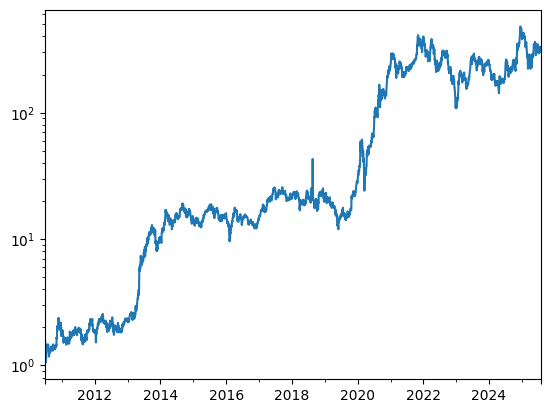

In [68]:
tesla = read_csv('tesla_practice.csv')

tesla = clean_data(tesla)

tesla['Close'].plot(logy=True)

In [85]:
df = pd.DataFrame({'close': tesla['Close'], 'open': tesla['Open']})

df['short_ma'] = df['close'].ewm(span=50, adjust=False).mean()
df['long_ma'] = df['close'].rolling(200).mean()

conditions = [
    df['short_ma'] > df['long_ma'],
    df['short_ma'] < df['long_ma'],
]
signal_choices = [1, -1]
df['signal'] = np.select(conditions, signal_choices, default=0)

# We dont care about the first entry being NaN because of warmup period
df['lagged_signal'] = df['signal'].shift(1)

df['open_to_next_open_return'] = df['open'].pct_change().shift(-1)

strategy_conditions = [
    df['lagged_signal'] == 1,
    df['lagged_signal'] == -1
]

strategy_return_choices = [
    df['open_to_next_open_return'],
    (1 / (1 + df['open_to_next_open_return'])) - 1
]
df['strategy_return'] = np.select(strategy_conditions, strategy_return_choices, default=0)

# Remove Warmup Period
df = df.iloc[200:].copy()

# last row of open_to_next_open_return and strategy_return are NaN
if pd.isna(df['open_to_next_open_return'].iloc[-1]):
    df.loc[df.index[-1], 'open_to_next_open_return'] = 0

if pd.isna(df['strategy_return'].iloc[-1]):
    df.loc[df.index[-1], 'strategy_return'] = 0

trade_days = df[df['lagged_signal'].diff().ne(0)].copy()
first_day = df.iloc[:1]
if first_day.index[0] not in trade_days.index:
    trade_days = pd.concat([first_day, trade_days]).sort_index()

trades_df = pd.DataFrame({
    'position': trade_days['lagged_signal'],
    'entry_date': trade_days.index,
    'entry_price': trade_days['open']
})

trades_df['exit_date'] = trades_df['entry_date'].shift(-1)
trades_df['exit_price'] = trades_df['entry_price'].shift(-1)

if not trades_df.empty:
    trades_df.loc[trades_df.index[-1], 'exit_date'] = df.index[-1]
    trades_df.loc[trades_df.index[-1], 'exit_price'] = df['open'].iloc[-1]

trades_df = trades_df[trades_df['position'] != 0].copy()

if not trades_df.empty:
    trades_df['pnl'] = np.where(
        trades_df['position'] == 1,
        trades_df['exit_price'] / trades_df['entry_price'],
        trades_df['entry_price'] / trades_df['exit_price']
    )
    trades_df['duration'] = trades_df['exit_date'] - trades_df['entry_date']

    wins = trades_df[trades_df['pnl'] > 1].shape[0]
    losses = trades_df[trades_df['pnl'] < 1].shape[0]
    win_loss_ratio = wins / losses if losses != 0 else float('inf')
    avg_duration = trades_df['duration'].mean()
    min_duration = trades_df['duration'].min()
    max_duration = trades_df['duration'].max()
else:
    no_time = pd.Timedelta(0)
    wins, losses, win_loss_ratio, avg_duration, min_duration, max_duration = 0, 0, 0, no_time, no_time, no_time

trades_pnl = trades_df['pnl'].prod()

best_trade = trades_df['pnl'].max()
worst_trade = trades_df['pnl'].min()
avg_trade = trades_df['pnl'].mean()

pnl_from_daily_returns = (1 + df['strategy_return']).prod()

# Sharpe Ratio
risk_free_rate = 0.045
daily_risk_free_rate = risk_free_rate / 365
excess_returns = df['strategy_return'] - daily_risk_free_rate
mean_return = excess_returns.mean()
std_return = excess_returns.std()
sharpe_ratio = 0.
if std_return > 0:
    sharpe_ratio = (mean_return / std_return) * np.sqrt(252)

# Sortino Ratio
neg_excess_returns = excess_returns[excess_returns < 1]
downside_std = neg_excess_returns.std()
sortino_ratio = np.inf
if downside_std > 0:
    sortino_ratio = (mean_return / downside_std) * np.sqrt(252)

# Plot strategy performance / equity curve
df['cumulative_return'] = (1 + df['strategy_return']).cumprod()

# Max Drawdown
running_max = df['cumulative_return'].expanding().max()
drawdown = (df['cumulative_return'] / running_max) - 1
max_drawdown = drawdown.min()

print(f"Total return from Trades: {trades_pnl:.4f}")
print(f"Total return from daily returns: {pnl_from_daily_returns:.4f}")

print(f"Win/Loss Ratio: {win_loss_ratio:.2f} ({wins} wins / {losses} losses)")
print(f"Min duration: {min_duration}")
print(f"Avg duration: {avg_duration}")
print(f"Max duration: {max_duration}")

print(f"Best Trade: {best_trade}")
print(f"Worst Trade: {worst_trade}")
print(f"Avg Trade: {avg_trade}")

print(f"Sharpe Ratio: {sharpe_ratio}")
print(f"Sharpe Ratio: {sortino_ratio}")

print(f"Max Drawdown: {max_drawdown}")



Total return from Trades: 4.1267
Total return from daily returns: 4.1267
Win/Loss Ratio: 0.25 (6 wins / 24 losses)
Min duration: 3 days 00:00:00
Avg duration: 174 days 09:36:00
Max duration: 754 days 00:00:00
Best Trade: 10.486262199680572
Worst Trade: 0.7068666926879057
Avg Trade: 1.4155521127296056
Sharpe Ratio: 0.40703537732076495
Sharpe Ratio: 0.4536931357294762
Max Drawdown: -0.8617206296772006
